# Solving Ordinary Differential Equations Using Neural Networks  

Neural networks typically train by backpropagating error signals from the training data. But what if we could impose additional constraints on the network’s output to guide learning? By incorporating **physical** constraints into the training process, we obtain **physics-informed neural networks (PINNs)**.  

In this post, we explore how PINNs can be used to solve ordinary differential equations (ODEs). This discussion is inspired by the work of [Hubert Baty, Leo Baty](https://arxiv.org/abs/2302.12260).  

### First Equation to Solve:  

$$
\frac{dy}{dt} + 0.1y - \sin\left(\frac{\pi t}{2}\right) = 0
$$  

Solving a differential equation means finding $ y(t) $ such that the equation holds. However, solving differential equations analytically is often infeasible. As a result, we typically rely on numerical schemes to approximate the solution. 

## Exact Solution Using Numerical Integration  

We will use the Runge-Kutta 4 (RK4) method as our numerical integrator to compute the trajectory of the solution over \( t \in [0, 30] \). The RK4 method approximates solutions by expressing the equation in terms of its first derivative:  

$$
\frac{dy}{dt} = \sin\left(\frac{\pi t}{2}\right) - 0.1y
$$

with the initial condition $ y(0) = 1 $.  

Using this formulation, the RK4 method estimates the change in $ y $ at each step based on a weighted average of derivative evaluations. Let’s see this in action:  

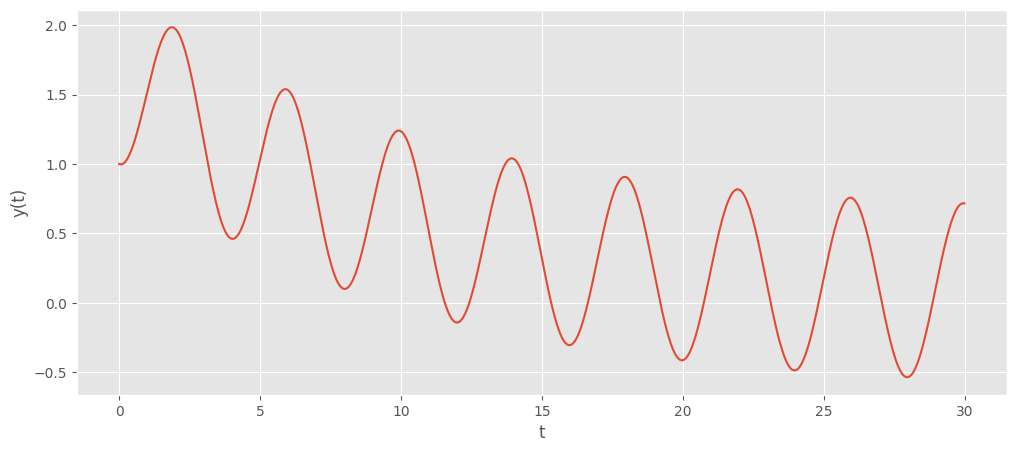

In [58]:
import matplotlib.pyplot as plt
import torch

plt.style.use("ggplot")

def rk4(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def solve_ode(f, t0, y0, t_end, h):
    t_values = torch.arange(t0, t_end + h, h)
    y_values = torch.zeros((len(t_values),) + y0.shape, dtype=torch.float32)
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4(f, t_values[i - 1], y_values[i - 1], h)

    return t_values.unsqueeze(1), y_values


def dy_dt(t, y):
    return torch.sin(torch.pi * t / 2) - 1 / 10 * y


# Initial conditions
t0 = 0.0
y0 = torch.tensor([1.0], dtype=torch.float32)
t_end = 30.0
h = 0.01

# Solve the ODE using RK4 method
t_values, y_values = solve_ode(dy_dt, t0, y0, t_end, h)

plt.figure(figsize=(12, 5))
plt.xlabel("t")
plt.ylabel("y(t)")
plt.plot(t_values, y_values)
plt.show()


This is the exact solution to the differential equation—well, not truly exact, since we’ve used a numerical integrator. However, for a simple, non-chaotic system like this, integrated over a small time scale, we can be quite confident in its accuracy.  

One important limitation to note is that this method requires stepping through the integrator sequentially. There is no function-like mechanism where we can simply input a time and get \( y \) instantly. Instead, we can only determine the state at time $t$ by starting from $t = 0$ and iterating forward.

## Use a neural network with no "physical" information

We can use neural networks as a universal approximator in order to try and learn the solution for $y(t)$. We can do this by taking a sample of the solution data set that we obtained using numerical integration, and iteratively learning based on these samples.

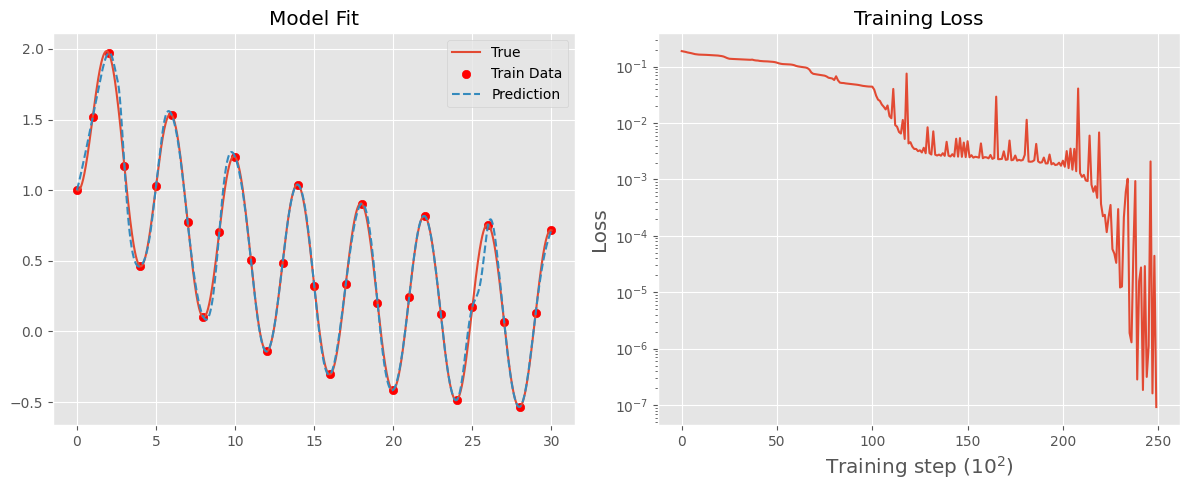

In [59]:
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(123)

class NN(nn.Module):
    def __init__(self, n_input=1, n_output=1, hidden_dim=32):

        super().__init__()

        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(n_input, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

def train_nn(lr, epochs, t_train, y_train):
    model = NN()
    optimiser = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for i in range(epochs):
        yh = model(t_train)
        loss = torch.mean((yh - y_train) ** 2)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if (i + 1) % 100 == 0:
            loss_history.append(loss.detach())

    with torch.no_grad():
        yh = model(t_values)

    return yh, loss_history

lr = 5e-3
epochs = 25000

t_train = t_values[::100]
y_train = y_values[::100]

yh, loss_history = train_nn(lr, epochs, t_train, y_train)
# Create a single figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the model results on the first subplot
axs[0].plot(t_values, y_values, label="True")
axs[0].scatter(t_train, y_train, color="red", label="Train Data")
axs[0].plot(t_values, yh, label="Prediction", linestyle="--")
axs[0].set_title("Model Fit")
axs[0].legend()

# Plot the loss history on the second subplot
axs[1].plot(loss_history)
axs[1].set_xlabel("Training step ($10^2$)", fontsize="x-large")
axs[1].set_ylabel("Loss", fontsize="x-large")
axs[1].set_yscale("log")
axs[1].set_title("Training Loss")

plt.tight_layout()
plt.show()

As we can see, the neural network converges to a good approximation of the differential equation’s solution just before 15,000 training epochs. Naturally, we can further refine the performance through hyperparameter tuning. In particular, we will examine different learning rates and their impact on the stability of the solution.

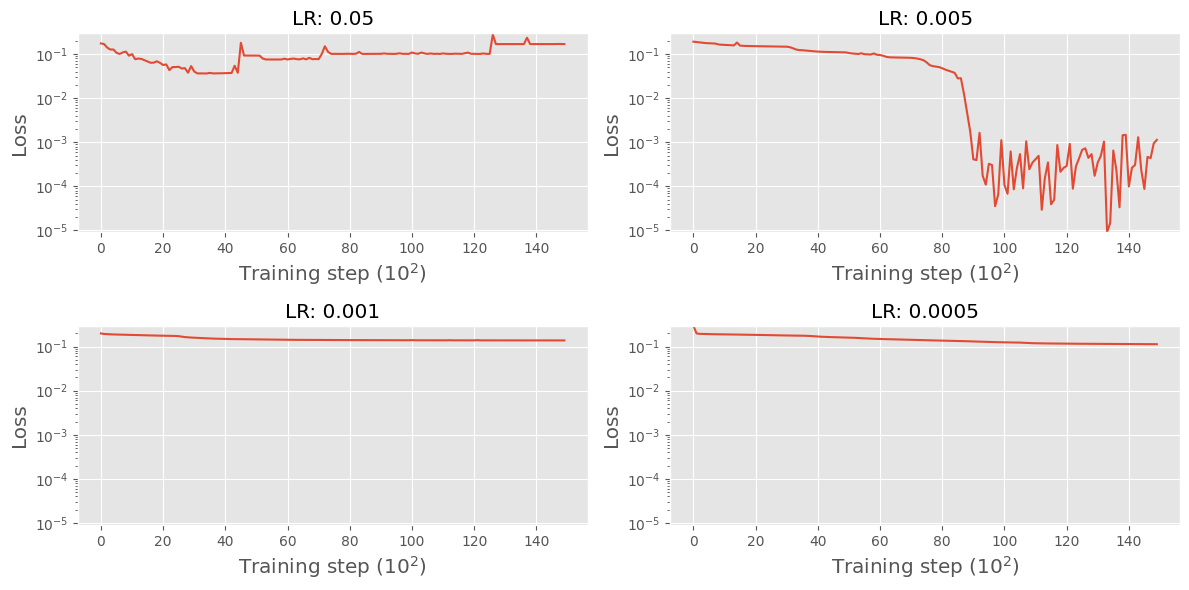

In [60]:
learning_rates = [5e-2, 5e-3, 1e-3, 5e-4]
rows, cols = 2, len(learning_rates) // 2  # Define the grid layout

all_loss_histories = []

for lr in learning_rates:

    yh, loss_history = train_nn(lr, 15000, t_train, y_train)

    all_loss_histories.append(loss_history)

# Find global min and max for standardizing y-axis
min_loss = min(min(loss) for loss in all_loss_histories)
max_loss = max(max(loss) for loss in all_loss_histories)

# Plot results

fig, axs = plt.subplots(rows, cols, figsize=(12, 6))
for idx, (lr, loss_history) in enumerate(zip(learning_rates, all_loss_histories)):
    row, col = divmod(idx, cols)  # Calculate row and column indices
    axs[row, col].plot(loss_history)
    axs[row, col].set_xlabel("Training step ($10^2$)", fontsize="x-large")
    axs[row, col].set_ylabel("Loss", fontsize="x-large")
    axs[row, col].set_yscale("log")
    axs[row, col].set_ylim(min_loss, max_loss)  # Standardize y-axis
    axs[row, col].set_title(f"LR: {lr}")

plt.tight_layout()
plt.show()

Admittedly, this is not an extensive hyperparameter tuning process, but the key takeaway is that training is highly sensitive to the learning rate—just as with standard neural networks. A learning rate that is too large can prevent training altogether.  

## Using a Physical Loss in the Neural Network  

So far, we have trained a neural network using data generated from the solution to the ODE, allowing it to approximate the underlying function. While this works, it presents a fundamental chicken-and-egg problem: we need data from the solution in order to approximate the solution. Although real-world data from physical processes is available in some cases, our goal is to solve the ODE without relying on data, instead using the constraints of the equation itself.  

The given ODE is:  

$$  
\frac{dy}{dt} + 0.1y - \sin\left(\frac{\pi t}{2}\right) = 0  
$$  

We can incorporate this constraint into training by treating the first-order derivative as a form of regularization. Specifically, we want to avoid updating the neural network’s parameters in a way that causes  

$$  
\mathcal{F} = \frac{dy}{dt} + 0.1y - \sin\left(\frac{\pi t}{2}\right)  
$$  

to deviate significantly from zero. This requires computing derivatives at specific points in the training process. These points are known as **collocation points**.  

### Collocation Points vs. Training Points  

A **training point** is an instance derived from the function we aim to approximate. In contrast, a **collocation point** is simply a time value where we evaluate $\mathcal{F}$.  

We now define a loss function that combines both standard training loss and the loss at collocation points:  

$$  
L(\theta) = \omega_{\text{data}} L_{\text{data}}(\theta) + w_{\mathcal{F}} L_{\mathcal{F}}(\theta)  
$$  

where  

$$  
L_{\mathcal{F}}(\theta) = \left\| \frac{dy_\theta}{dt} + 0.1y_\theta - \sin\left(\frac{\pi t}{2}\right) \right\|.  
$$

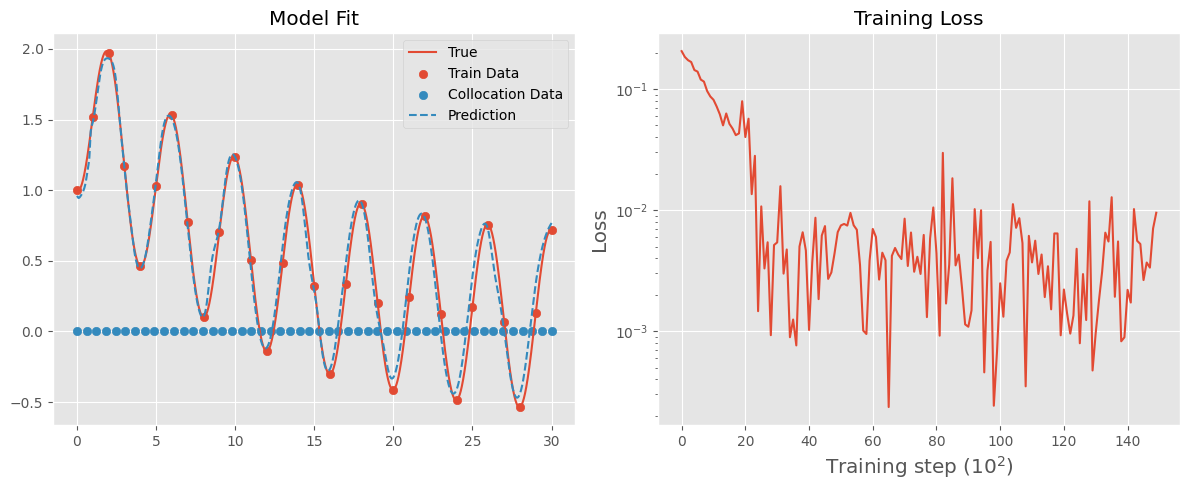

In [62]:
def train_pinn(lr, epochs, t_train, y_train, p_train):
    model = NN()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    physics_loss_history = []

    for i in range(epochs):

        # Prediction Loss
        yh = model(t_train)
        pred_loss = torch.mean((yh - y_train) ** 2)

        yhp = model(p_train)
        dx = torch.autograd.grad(yhp, p_train, torch.ones_like(yhp), create_graph=True)[
            0
        ]

        cal_F = dx + 0.1 * yhp - torch.sin(torch.pi * p_train / 2)
        physics_loss = (6e-2) * (torch.mean(cal_F**2))

        loss = pred_loss + physics_loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if (i+1) % 100 == 0:
            loss_history.append(loss.detach())
            physics_loss_history.append(physics_loss.detach())

    with torch.no_grad():
        yh = model(t_values)

    return yh, loss_history, physics_loss_history


p_train = torch.linspace(0, 30, 50).unsqueeze(1).requires_grad_(True)
p_train_zeros = torch.zeros_like(p_train).detach()

yh, loss_history, physics_loss_history = train_pinn(3e-2, 15000, t_train, y_train, p_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(t_values, y_values, label="True")
axs[0].scatter(t_train, y_train, label="Train Data")
axs[0].scatter(p_train.detach(), p_train_zeros, label="Collocation Data")
axs[0].plot(t_values, yh, label="Prediction", linestyle="--")
axs[0].set_title("Model Fit")
axs[0].legend()

axs[1].plot(loss_history)
axs[1].set_xlabel("Training step ($10^2$)", fontsize="x-large")
axs[1].set_ylabel("Loss", fontsize="x-large")
axs[1].set_yscale("log")
axs[1].set_title("Training Loss")

plt.tight_layout()
plt.show()

The first key observation is that incorporating the physical loss into training has allowed us to increase the learning rate from $0.005$ to $0.03$. As a result, the neural network converges to a good approximation of the solution in just **4000 iterations**. However, a fundamental issue remains: the neural network still relies on data from the true solution to train.  

The final challenge for the **Physics-Informed Neural Network (PINN)** is to eliminate this dependency entirely. Instead of using solution data, the goal is to train the network using only the **initial conditions** of the problem and the **collocation points** derived from the governing differential equation. By doing so, the PINN can learn an approximation of the true solution without requiring any precomputed training data.  

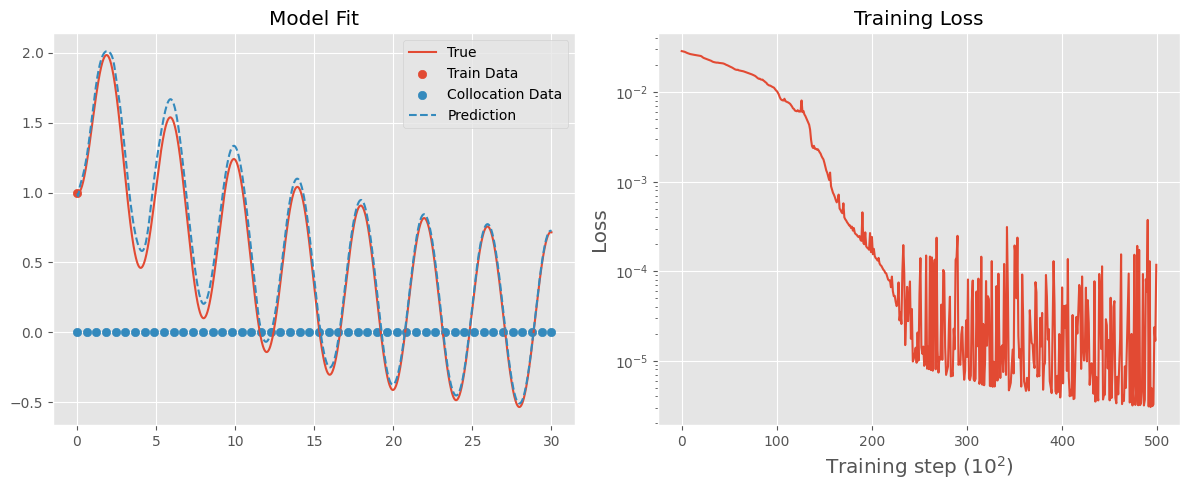

In [55]:
initial_x, initial_y = torch.Tensor([[0]]), torch.Tensor([[1]])

yh, loss_history, physics_loss_history =  train_pinn(
    5e-3, 50000, initial_x, initial_y, p_train
)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(t_values, y_values, label="True")
axs[0].scatter(initial_x, initial_y, label="Train Data")
axs[0].scatter(p_train.detach(), p_train_zeros, label="Collocation Data")
axs[0].plot(t_values, yh, label="Prediction", linestyle="--")
axs[0].set_title("Model Fit")
axs[0].legend()

axs[1].plot(loss_history)
axs[1].set_xlabel("Training step ($10^2$)", fontsize="x-large")
axs[1].set_ylabel("Loss", fontsize="x-large")
axs[1].set_yscale("log")
axs[1].set_title("Training Loss")

plt.tight_layout()
plt.show()

## Conclusion  

In this post, we explored how **Physics-Informed Neural Networks (PINNs)** can be used to solve ordinary differential equations by embedding physical constraints directly into the learning process. Initially, we trained a neural network using data generated from the true solution of the ODE, but this approach required access to the solution beforehand—defeating the purpose of solving the equation in the first place.  

By incorporating a **physics-based loss function**, we allowed the network to learn in a way that respects the structure of the differential equation itself. This not only improved convergence but also enabled us to increase the learning rate, significantly reducing the number of training iterations required.  

Most importantly, we demonstrated that a PINN can successfully approximate the solution **using only the initial condition and collocation points**, without needing any data from the true solution. This highlights the power of physics-informed learning: instead of relying on large datasets, the network leverages fundamental governing equations to infer an accurate solution.  

The success of PINNs in this simple ODE example suggests their potential for solving more complex differential equations, including those arising in physics, engineering, and other scientific domains. Future work could explore extensions to **partial differential equations (PDEs)**, multi-physics systems, and real-world applications where data is scarce but physical laws are well understood.  